# Subgroup Robustness Grows on Trees (Experiments)
Here are some initial experiments corroborating the empirical observations from *Subgroup Robustness Grows on Trees*.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSEmployment

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# ACS Employment Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual is employed, after filtering the survey sample to only include individuals between the ages of 16 and 90.
The full dataset has $n = 3,236,107$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 376,035$ examples total.

## Preprocess and Clean ACS Employment
The ACS Employment dataset (California, 2016) is a binary classification task with $d=16$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [2]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
features.shape

(376035, 16)

In [3]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [4]:
to_one_hot = set(['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'DREM', 'RAC1P'])
to_leave_alone = set(ACSEmployment.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
col_transf = ColumnTransformer(steps)
features_t = col_transf.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (376035, 69)


In [5]:
# Train-test split
splits = train_test_split(*tuple([features, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	300828	75207
1 (R1)	184961	46271
2 (R2)	15047	3784
3 (R3)	2080	517
4 (R6)	45385	11425
5 (R7)	1057	280
6 (R8)	37135	9181
7 (R9)	14416	3562
8 (S1)	148622	36981
9 (S2)	152206	38226
10 (A1)	254184	63388
11 (A2)	46644	11819


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


# Gradient-Boosted Trees

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pickle
import os

In [11]:
# Hyperparameter sweep for GBM
PARAM_PATH = 'employment_trees_params/'
with open(os.path.join(PARAM_PATH, 'best_gb_params_avg.pkl'), 'rb') as handle:
    best_gb_params_avg = pickle.load(handle)
with open(os.path.join(PARAM_PATH, 'best_gb_params_worstgp.pkl'), 'rb') as handle:
    best_gb_params_worstgp = pickle.load(handle)

print(best_gb_params_avg)
print(best_gb_params_worstgp)
print("Average and worst group are the same? {}".format(best_gb_params_avg == best_gb_params_worstgp))

{'learning_rate': 0.1, 'max_depth': 8, 'random_state': 0, 'n_estimators': 128}
{'learning_rate': 1.0, 'max_depth': 2, 'random_state': 0, 'n_estimators': 128}
Average and worst group are the same? False


In [12]:
# Refit the best estimators (worst-group and average accuracy)
gb_model_avg = GradientBoostingClassifier(**best_gb_params_avg)
gb_model_avg.fit(col_transf.transform(X_train), y_train)
gb_model_worstgp = GradientBoostingClassifier(**best_gb_params_worstgp)
gb_model_worstgp.fit(col_transf.transform(X_train), y_train)

avg_acc = accuracy_score(gb_model_avg.predict(col_transf.transform(X_test)), y_test)
print("Average accuracy (GB-avg): {}".format(avg_acc))
yhats = gb_model_avg.predict(col_transf.transform(X_test))

print("Average accuracy (GB-worstgp): {}".format(accuracy_score(gb_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
yhats = gb_model_worstgp.predict(col_transf.transform(X_test))

Average accuracy (GB-avg): 0.8199901604903799
Worst-group accuracy (GB-avg): 0.8185472542197056
Average accuracy (GB-worstgp): 0.8186472003935804
Worst-group accuracy (GB-worstgp): 0.8174234401677076


In [14]:
# For each GB model, record the stage-wise loss (per group)
worstgp_gb_test_errs = {}   # dict of group -> errors for each stage
worstgp_gb_train_errs = {}
staged_preds = list(gb_model_worstgp.staged_predict(col_transf.transform(X_test)))
staged_preds_train = list(gb_model_worstgp.staged_predict(col_transf.transform(X_train)))
for g in range(num_groups):
    worstgp_gb_test_errs[g] = list()
    worstgp_gb_train_errs[g] = list()
    for stage in range(gb_model_worstgp.n_estimators_):
        yhats_stage = staged_preds[stage]
        yhats_stage_train = staged_preds_train[stage]
        worstgp_gb_test_errs[g].append(np.mean(y_test[group_test[g]] != yhats_stage[group_test[g]]))
        worstgp_gb_train_errs[g].append(np.mean(y_train[group_train[g]] != yhats_stage_train[group_train[g]]))

avg_gb_test_errs = {}   # dict of group -> errors for each stage
avg_gb_train_errs = {}
staged_preds = list(gb_model_worstgp.staged_predict(col_transf.transform(X_test)))
staged_preds_train = list(gb_model_worstgp.staged_predict(col_transf.transform(X_train)))
for g in range(num_groups):
    avg_gb_test_errs[g] = list()
    avg_gb_train_errs[g] = list()
    for stage in range(gb_model_worstgp.n_estimators_):
        yhats_stage = staged_preds[stage]
        yhats_stage_train = staged_preds_train[stage]
        avg_gb_test_errs[g].append(np.mean(y_test[group_test[g]] != yhats_stage[group_test[g]]))
        avg_gb_train_errs[g].append(np.mean(y_train[group_train[g]] != yhats_stage_train[group_train[g]]))

In [30]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


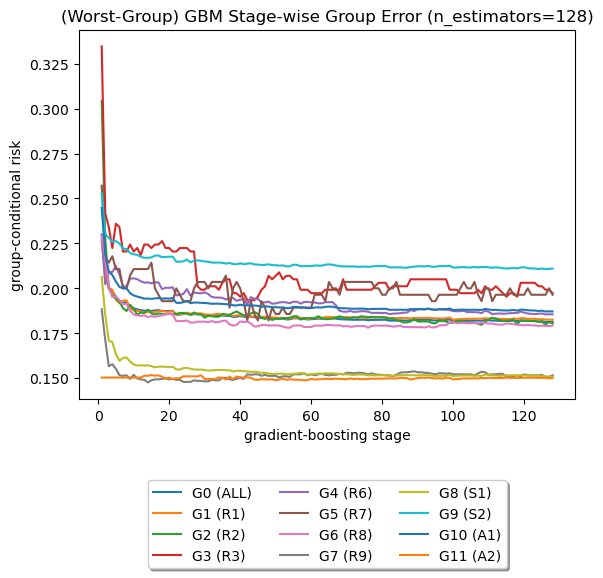

In [15]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = gb_model_worstgp.n_estimators_
fig, ax = plt.subplots()
group_stagewise_errs = worstgp_gb_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Worst-Group) GBM Stage-wise Group Test Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

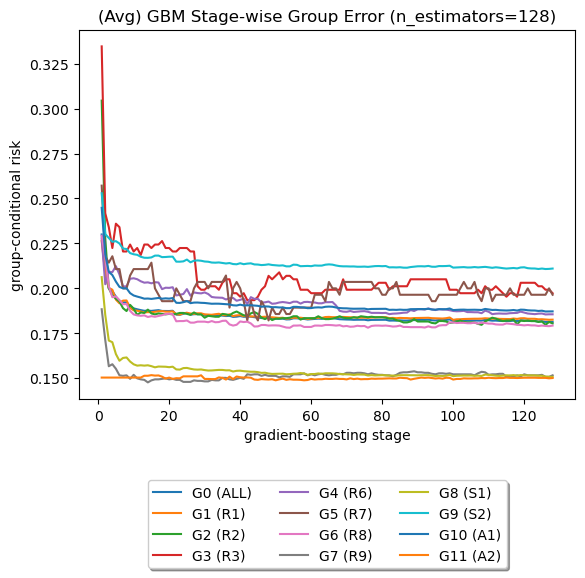

In [16]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = gb_model_avg.n_estimators_
fig, ax = plt.subplots()
group_stagewise_errs = avg_gb_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Avg) GBM Stage-wise Group Test Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

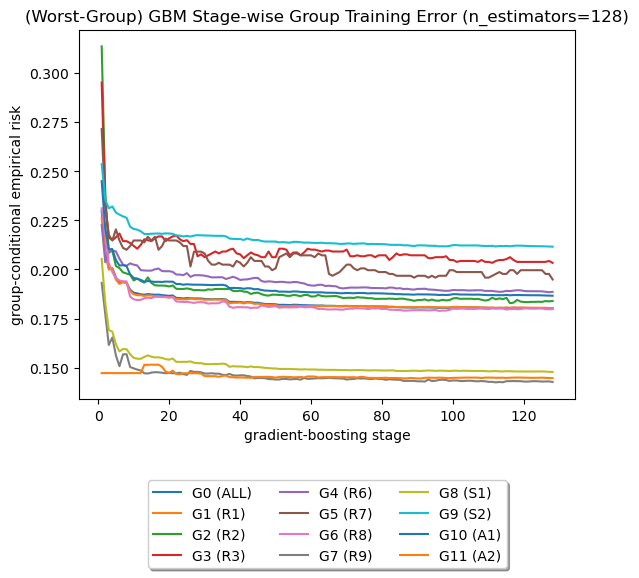

In [17]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = gb_model_worstgp.n_estimators_
fig, ax = plt.subplots()
group_stagewise_errs = worstgp_gb_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional empirical risk")
ax.set_title("(Worst-Group) GBM Stage-wise Group Training Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

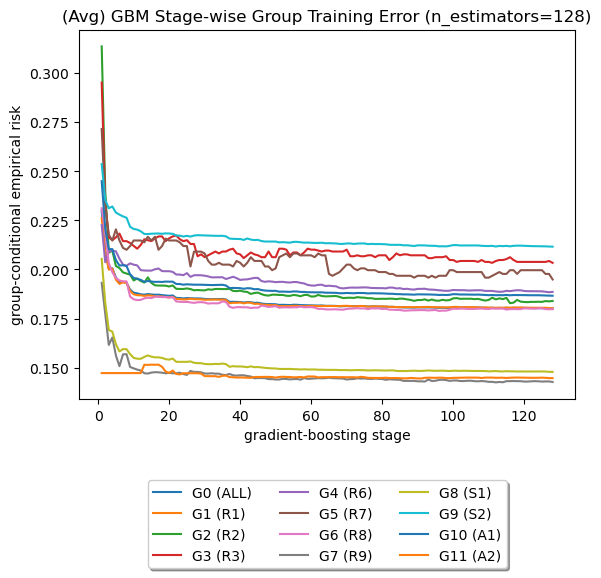

In [18]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = gb_model_avg.n_estimators_
fig, ax = plt.subplots()
group_stagewise_errs = avg_gb_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional empirical risk")
ax.set_title("(Avg) GBM Stage-wise Group Training Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

# XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [20]:
# Hyperparameter sweep for GBM
PARAM_PATH = 'employment_trees_params/'
with open(os.path.join(PARAM_PATH, 'best_xgb_params_avg.pkl'), 'rb') as handle:
    best_xgb_params_avg = pickle.load(handle)
with open(os.path.join(PARAM_PATH, 'best_xgb_params_worstgp.pkl'), 'rb') as handle:
    best_xgb_params_worstgp = pickle.load(handle)

print(best_xgb_params_avg)
print(best_xgb_params_worstgp)
print("Average and worst group are the same? {}".format(best_xgb_params_avg == best_xgb_params_worstgp))

{'learning_rate': 0.5, 'max_depth': 4, 'random_state': 0, 'n_estimators': 128}
{'learning_rate': 0.5, 'max_depth': 6, 'random_state': 0, 'n_estimators': 128}
Average and worst group are the same? False


In [21]:
# Refit the best estimators (worst-group and average accuracy)
best_xgbs_avg = {}
overall_avg_accs = list()
best_xgbs_worstgp = {}
overall_worstgp_accs = list()

xgb_model_avg = XGBClassifier(**best_xgb_params_avg)
xgb_model_avg.fit(col_transf.transform(X_train), y_train)
xgb_model_worstgp = XGBClassifier(**best_xgb_params_worstgp)
xgb_model_worstgp.fit(col_transf.transform(X_train), y_train)

avg_acc = accuracy_score(xgb_model_avg.predict(col_transf.transform(X_test)), y_test)
print("Average accuracy (XGB-avg): {}".format(avg_acc))
yhats = xgb_model_avg.predict(col_transf.transform(X_test))

print("Average accuracy (XGB-worstgp): {}".format(accuracy_score(xgb_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
yhats = xgb_model_worstgp.predict(col_transf.transform(X_test))

Average accuracy (XGB-avg): 0.8195912614517266
Average accuracy (XGB-worstgp): 0.8190726927014772


In [22]:
# Need to do staged_predict manually
# For each XGB model, record the stage-wise loss (per group)
num_stages = xgb_model_avg.get_num_boosting_rounds()
worstgp_xgb_test_errs = {}   # dict of group -> errors for each stage
worstgp_xgb_train_errs = {}
avg_xgb_test_errs = {}   # dict of group -> errors for each stage
avg_xgb_train_errs = {}
avg_staged_preds = list()
avg_staged_preds_train = list()
worstgp_staged_preds = list()
worstgp_staged_preds_train = list()

for stage in range(1, num_stages + 1):
    avg_staged_preds_train.append(xgb_model_avg.predict(col_transf.transform(X_train), iteration_range=(0, stage)))
    avg_staged_preds.append(xgb_model_avg.predict(col_transf.transform(X_test), iteration_range=(0, stage)))
for stage in range(1, num_stages + 1):
    worstgp_staged_preds_train.append(xgb_model_worstgp.predict(col_transf.transform(X_train), iteration_range=(0, stage)))
    worstgp_staged_preds.append(xgb_model_worstgp.predict(col_transf.transform(X_test), iteration_range=(0, stage)))

for g in range(num_groups):
    worstgp_xgb_test_errs[g] = list()
    worstgp_xgb_train_errs[g] = list()
    avg_xgb_test_errs[g] = list()
    avg_xgb_train_errs[g] = list()
    for stage in range(num_stages):
        avg_yhats_stage = avg_staged_preds[stage]
        avg_yhats_stage_train = avg_staged_preds_train[stage]
        avg_xgb_train_errs[g].append(np.mean(y_train[group_train[g]] != avg_yhats_stage_train[group_train[g]]))
        avg_xgb_test_errs[g].append(np.mean(y_test[group_test[g]] != avg_yhats_stage[group_test[g]]))

        worstgp_yhats_stage = worstgp_staged_preds[stage]
        worstgp_yhats_stage_train = worstgp_staged_preds_train[stage]
        worstgp_xgb_train_errs[g].append(np.mean(y_train[group_train[g]] != worstgp_yhats_stage_train[group_train[g]]))
        worstgp_xgb_test_errs[g].append(np.mean(y_test[group_test[g]] != worstgp_yhats_stage[group_test[g]]))

In [31]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


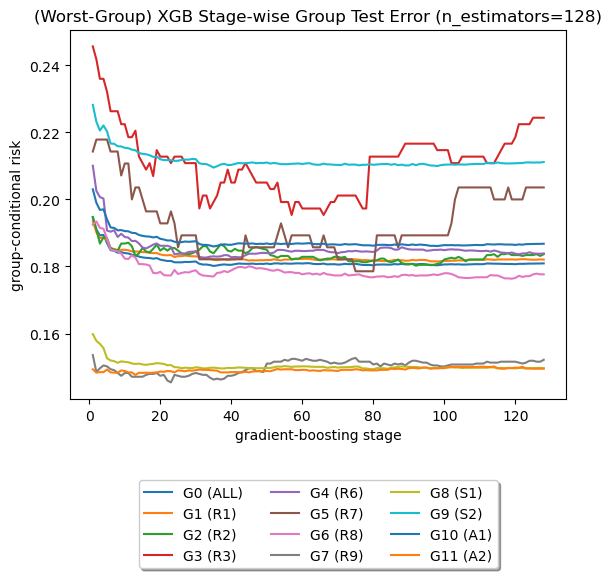

In [23]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_worstgp.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = worstgp_xgb_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Worst-Group) XGB Stage-wise Group Test Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

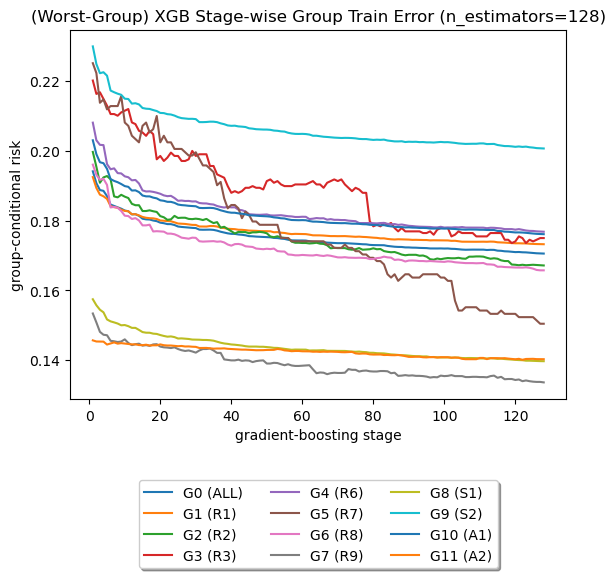

In [24]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_worstgp.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = worstgp_xgb_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Worst-Group) XGB Stage-wise Group Train Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

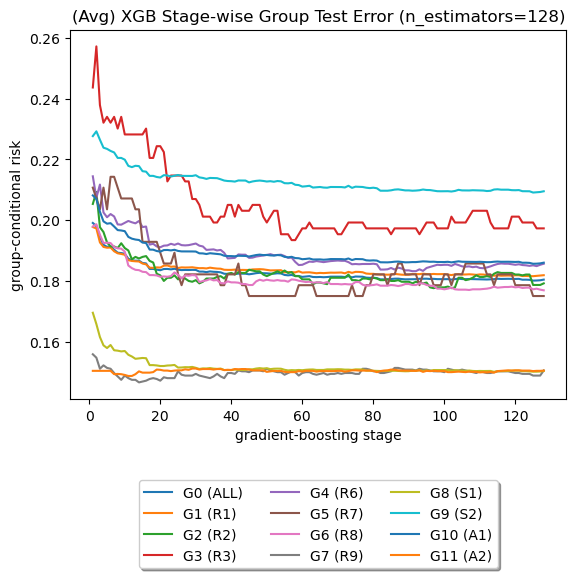

In [25]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_worstgp.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = avg_xgb_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Avg) XGB Stage-wise Group Test Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

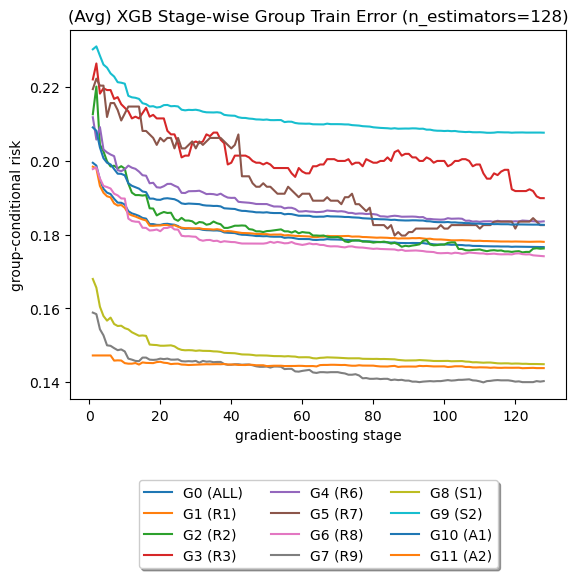

In [26]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_worstgp.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = avg_xgb_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("(Avg) XGB Stage-wise Group Train Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

# AdaBoost (with Decision Stumps)

In [27]:
from sklearn.ensemble import AdaBoostClassifier

In [28]:
with open(os.path.join(PARAM_PATH, 'best_ada_params_avg.pkl'), 'rb') as handle:
    best_ada_params_avg = pickle.load(handle)
with open(os.path.join(PARAM_PATH, 'best_ada_params_avg.pkl'), 'rb') as handle:
    best_ada_params_worstgp = pickle.load(handle)

print(best_ada_params_avg)
print(best_ada_params_worstgp)
print("Average and worst group are the same? {}".format(best_ada_params_avg == best_ada_params_worstgp))

{'learning_rate': 0.1, 'random_state': 0, 'n_estimators': 128}
{'learning_rate': 0.1, 'random_state': 0, 'n_estimators': 128}
Average and worst group are the same? True


In [29]:
# Refit the best estimators (worst-group and average accuracy)
best_ada_avg = {}
overall_avg_accs = list()
best_ada_worstgp = {}
overall_worstgp_accs = list()

ada_model_avg = AdaBoostClassifier(**best_ada_params_avg)
ada_model_avg.fit(col_transf.transform(X_train), y_train)
ada_model_worstgp = AdaBoostClassifier(**best_ada_params_worstgp)
ada_model_worstgp.fit(col_transf.transform(X_train), y_train)

avg_acc = accuracy_score(ada_model_avg.predict(col_transf.transform(X_test)), y_test)
print("Average accuracy (AdaBoost-avg): {}".format(avg_acc))

print("Average accuracy (AdaBoost-worstgp): {}".format(accuracy_score(ada_model_worstgp.predict(col_transf.transform(X_test)), y_test)))

Average accuracy (AdaBoost-avg): 0.8096852686585025
Average accuracy (AdaBoost-worstgp): 0.8096852686585025


In [32]:
# For each AdaBoost model, record the stage-wise loss (per group)
ada_test_errs = {}   # dict of group -> errors for each stage
ada_train_errs = {}
staged_preds = list(ada_model_worstgp.staged_predict(col_transf.transform(X_test)))
staged_preds_train = list(ada_model_worstgp.staged_predict(col_transf.transform(X_train)))
for g in range(num_groups):
    ada_test_errs[g] = list()
    ada_train_errs[g] = list()
    for stage in range(len(ada_model_worstgp.estimators_)):
        yhats_stage = staged_preds[stage]
        yhats_stage_train = staged_preds_train[stage]
        ada_test_errs[g].append(np.mean(y_test[group_test[g]] != yhats_stage[group_test[g]]))
        ada_train_errs[g].append(np.mean(y_train[group_train[g]] != yhats_stage_train[group_train[g]]))

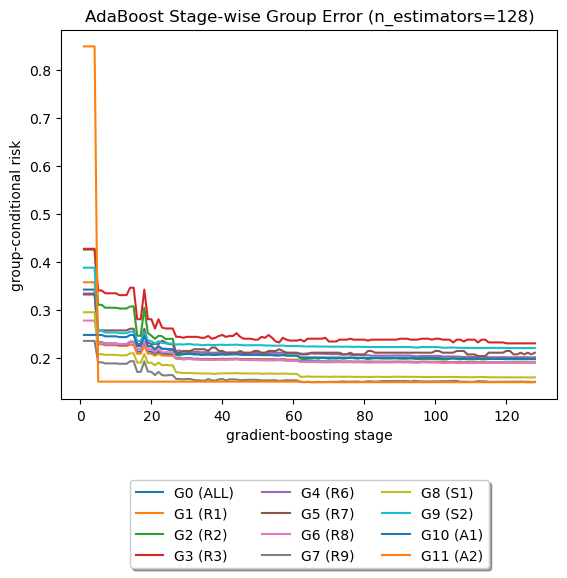

In [33]:
# For each AdaBoost model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = len(ada_model_worstgp.estimators_)
fig, ax = plt.subplots()
group_stagewise_errs = ada_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("AdaBoost Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

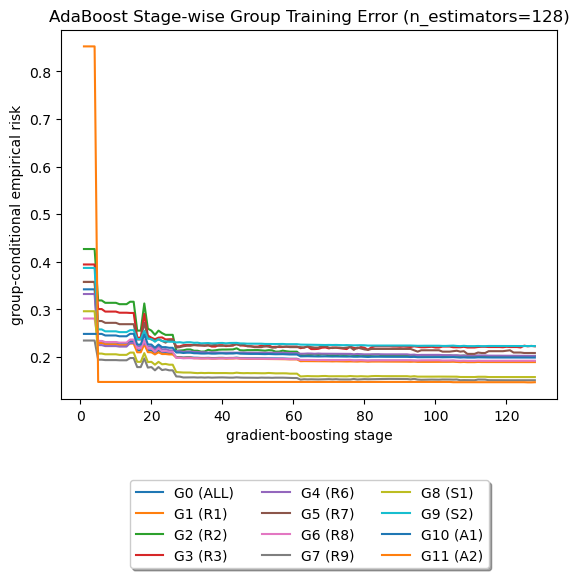

In [34]:
# For each AdaBoost model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = len(ada_model_worstgp.estimators_)
fig, ax = plt.subplots()
group_stagewise_errs = ada_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional empirical risk")
ax.set_title("AdaBoost Stage-wise Group Training Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)